# GNN Exploration

In [1]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
print(parent)

d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis


# ACQUIRE DATESET
The purpose of the below code is to construct the dataset for GNN. This involves taking BACH and: 1) Doing cell segmentation, 2) Construct the graphs. 
THe First step is very time consuming so the code below does the computation and saves it. THen we can do 2 seperatly at run time and have hyper parameters that vary how the graphs are constructed

In [2]:
# HOVERNET MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet
checkpoint_path = os.path.join(parent,"model","HoVerNet_Pan_Pre.ckpt")

cell_seg_model = HoVerNet.load_from_checkpoint(checkpoint_path, RESNET_SIZE=50,START_LR=0,categories=True)

from src.datasets.BACH import BACH
src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
prc_folder = os.path.join(parent,"data","processed","BACH_TRAIN","INSTANCE_SEGMENTATION")

In [3]:
# DATA

from tqdm import tqdm
from PIL import Image
from src.transforms.graph_construction.hovernet_post_processing import *
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import adjust_sharpness
from src.utilities.img_utilities import tensor_to_numpy
import matplotlib.pyplot as plt
from src.vizualizations.cellseg_viz import instance_segmentation_vizualised
from threading import Thread
from src.utilities.img_utilities import tensor_to_numpy

tile_size = 128

def save_viz(img,ins,cat,path):
    instance_segmentation_vizualised(img, ins,cat,figsize=(40,40))
    plt.savefig(path)

def generate_instance_masks(): # USE OF SHARPEN IS IMPORTANT TO CREATE MORE DISTINCTIVE CELLS
    """Takes all the BACH images and performs instance segmentation so that the graph constructors may be called later.
    """
    bach = BACH(src_folder,ids=list(range(1,401)))

    img_transform = Compose(
                [ToTensor()]) #(lambda x: adjust_sharpness(x,20))])
    normalizer = Normalize((0.6441, 0.4474, 0.6039), (0.1892, 0.1922, 0.1535))
    threads = []
    for path in tqdm(bach.original_image_paths, desc="Creating Instance Segmentation from BACH"):
        img = Image.open(path)
        
        orig_img = img_transform(img)
        img = normalizer(orig_img.clone())
        
        ins_pred,cat_pred = instance_mask_prediction_hovernet(cell_seg_model, img, tile_size=tile_size, pre_normalized=True,h=0.5,k=0.7)
        
        img = cut_img_from_tile(img, tile_size=tile_size)
        orig_img = cut_img_from_tile(orig_img, tile_size=tile_size)
        
        assert img.shape[1:] == ins_pred.shape[:]
        
        data = {"image": img, "instance_mask": ins_pred,"original_image": orig_img,"cell_categories":torch.as_tensor(cat_pred)} #ORIGINAL IMAGE CUT, THANK GOODNESS!!!! # image = cut image + norm, original_image = cut_image
        file_name = os.path.basename(path)[:-4] + ".pt"
        proc_path = os.path.join(bach.instance_segmentation_dir, file_name)
        
        viz_path = os.path.join(bach.instance_segmentation_dir,"VIZUALISED", file_name[:-3] + ".png")
        #thread = Thread(target=save_viz,args = (tensor_to_numpy(orig_img).copy(),np.asarray(ins_pred).copy(),cat_pred.copy(),viz_path))
        #thread.start()
        #threads.append(thread)
        #save_viz(tensor_to_numpy(orig_img).copy(),np.asarray(ins_pred).copy(),cat_pred.copy(),viz_path)
        torch.save(data, proc_path)
        
    for thread in tqdm(threads,desc="Hollowers"):
        thread.join()

Creating Instance Segmentation from BACH: 100%|██████████| 1/1 [03:51<00:00, 231.18s/it]
Hollowers: 0it [00:00, ?it/s]


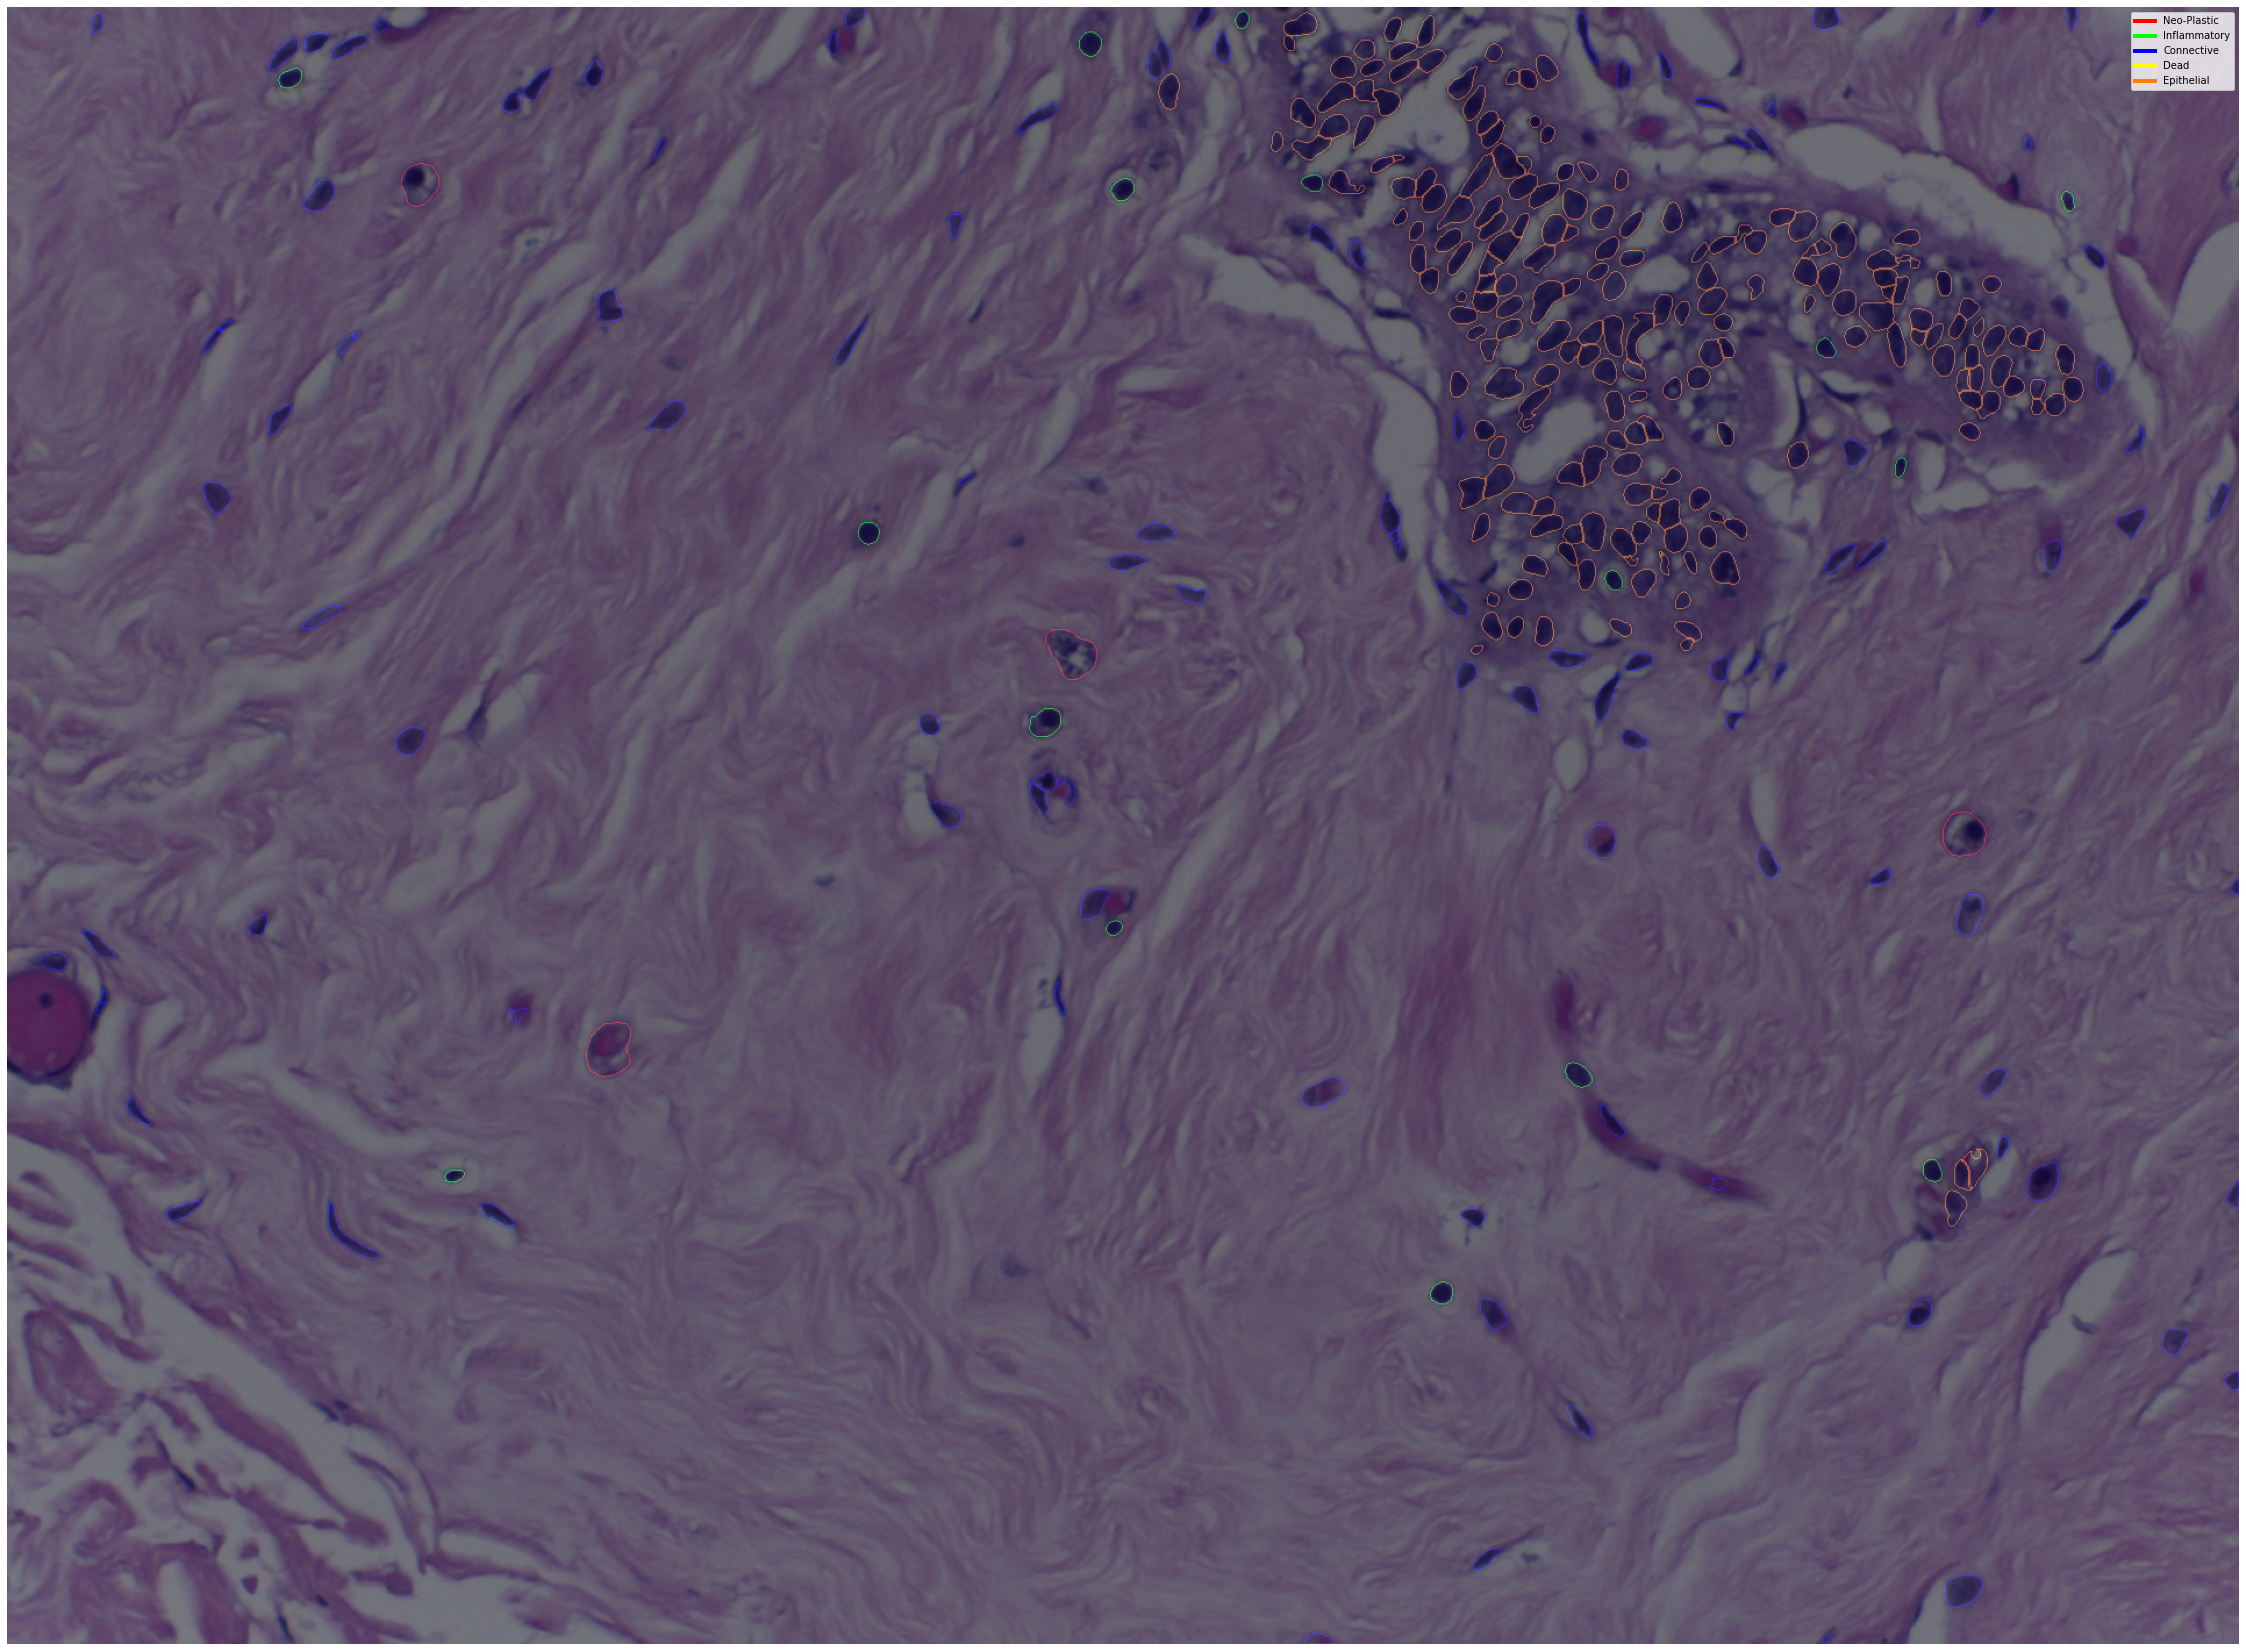

In [4]:
generate_instance_masks()

In [5]:
# Make sure saved properly and loading properly
from src.vizualizations.cellseg_viz import instance_segmentation_vizualised
import matplotlib.pyplot as plt
import torch


if False:
    bach = BACH(src_folder,ids=list(range(125,250)))
    for f in tqdm(bach.instance_segmentation_file_names, desc="Hollowing Instances"):

        sample = torch.load(os.path.join(bach.instance_segmentation_dir,f))
        instance_segmentation_vizualised(sample["original_image"], sample["instance_mask"].squeeze(),figsize=(100,100))
        plt.savefig(os.path.join(bach.instance_segmentation_dir,"VIZUALISED",f[:-3] + ".png"),bbox_inches='tight', pad_inches=0)

# Generate Graphs

In [6]:
from src.transforms.graph_construction.graph_extractor import extract_graph,mean_pixel_extraction, principle_pixels_extraction,quantiles_pixel_extraction

src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
bach = BACH(src_folder,dmin=150,k=6,window_size=64,downsample=1, min_nodes=10) #10 for k seems to high, maybe 5 would be better
#bach.generate_graphs(num_workers=3)
print(len(bach.graph_file_names))

0


### Generate the distribution

In [7]:
#dist = bach.generate_node_distribution()
# print(dist)

# Challenging Images:
After running the instance segmentation and then graph generation, there were some images that produced graphs with no nodes. They were:
- b067
- n026
- n045
- b052
- b054

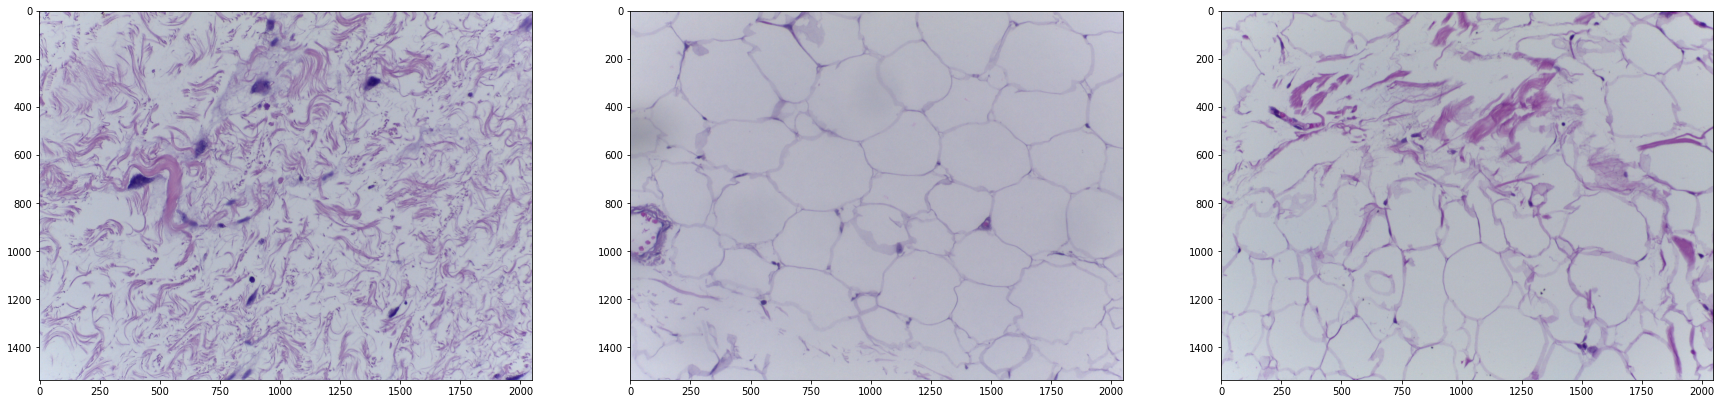

In [8]:
bad_img_pth = [os.path.join(src_folder,"Benign","b067.tif"),os.path.join(src_folder,"Normal","n026.tif"),os.path.join(src_folder,"Normal","n045.tif")]
bad_images = [Image.open(pth) for pth in bad_img_pth]

f,ax = plt.subplots(1,len(bad_images),figsize=(30,30*len(bad_images)))
for i in range(len(bad_images)):
    ax[i].imshow(bad_images[i])
plt.show()

# Results

In [9]:
from src.utilities.img_utilities import tensor_to_numpy
from src.vizualizations.image_viz import plot_images
from torchvision.transforms.functional import resize
from src.transforms.graph_construction.graph_extractor import extract_graph, mean_pixel_extraction,quantiles_pixel_extraction, principle_pixels_extraction

def visualize_graph(graph,ins_seg,upsample=1):

    dimensions = tuple(ins_seg['image'].shape[1:])
    print(dimensions)
    final = torch.zeros(3,*dimensions)
    for i,cell in enumerate(graph.x):
        pixels = len(cell)
        n_shape = (3,int((pixels//3)**0.5),int((pixels//3)**0.5))
        img = cell.unflatten(0,n_shape)
        img_n_dim = tuple(torch.as_tensor(img.shape[1:])*upsample)
        img = resize(img,size=img_n_dim)
        wd,ht = tuple(img.shape[1:])
        x,y = tuple(graph.pos[i])
        row,col = int(y.item()),int(x.item())
        
        final[:,row-ht//2:row+ht//2,col-wd//2:col+wd//2] = 1
    
    f,ax = plt.subplots(2,1,figsize=(50,40))
    ax[0].imshow(tensor_to_numpy(ins_seg['original_image']))
    ax[1].imshow(tensor_to_numpy(final*ins_seg['original_image']))
    for edge in graph.edge_index.t():
        a,b = graph.pos[edge[0]],graph.pos[edge[1]]
        ax[1].plot([a[0],b[0]],[a[1],b[1]],c="r")
    ax[1].scatter(graph.pos[:,0],graph.pos[:,1],c="g",s=20)
    plt.show()


#ins_seg = torch.load(os.path.join(prc_folder,"b002.pt"))

#graph = extract_graph(ins_seg['image'],ins_seg['instance_mask'],dmin=120,k=6,window_size=64,downsample=2,min_nodes=10,img_trans = quantiles_pixel_extraction)

#visualize_graph(graph,ins_seg)

# Decisions

Looking at the graphs, I notice that most contain one large, fully connected island, and then some small islands with a couple of nodes. I do not think these small islands are very informative, so I will remove these by altering the graph extraction algorithm

# Graphs Vizualiased

In [10]:
import networkx as nx
from torch_geometric.utils import to_networkx
from src.transforms.graph_augmentation.largest_component import LargestComponent
from torch_geometric.transforms import KNNGraph,Compose,Distance, RandomTranslate

def viz_graph_nx(graph):
    
#"b", "is", "iv", "n"
    c = ["white","green","red","black","blue"]
    colours = list(map(lambda x: c[x],((graph.x.argmax(dim=1)+1)*(graph.x.max(dim=1).values>0.1).int()).tolist()))

    G = to_networkx(graph,to_undirected=True)
    print(G)
    pos = {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}

    f,ax = plt.subplots(1,1,figsize=(70,70))
    nx.draw(G,pos=pos,node_color=colours)
    plt.show()
src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
bach = BACH(src_folder,pred_mode=True) #10 for k seems to high, maybe 5 would be better
graph = bach[135]



aug = Compose([RandomTranslate(10),KNNGraph(k=10),Distance(cat=False),])
viz_graph_nx(graph)
viz_graph_nx(aug(graph))


ZeroDivisionError: integer division or modulo by zero

# PROB GRAPH EXTRACTOR

In [ ]:
from src.model.architectures.cancer_prediction.cell_unet_ae import UNET_AE
import json
if False:
    src_folder = os.path.join("data", "processed", "BACH_TRAIN")
    args = json.load(open(os.path.join(parent, "experiments", "args", "ae.json")))
    model = UNET_AE.load_from_checkpoint(os.path.join(
        parent, "experiments", "checkpoints", "AE_UNET_PREDICTOR.ckpt"), **args)
    with torch.no_grad():
        model.eval()
        model = model.cuda()

        bach_prob = BACH(src_folder, downsample=1)
        bach_prob.generate_prob_graphs(model)

# Set Accuracy

In [ ]:
from PIL import Image
from torch.nn.functional import nll_loss,cross_entropy
src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
bach = BACH(src_folder,pred_mode=True) #10 for k seems to high, maybe 5 would be better

corr_mode = 0
corr_mean =0
canc_corr = 0
points = [21, 4, 68, 23, 28, 9, 63, 61, 84, 94, 46, 54, 55, 2, 7, 53, 76, 78, 1, 29, 124, 123, 199, 190, 170, 118, 153, 141, 120, 176, 129, 106, 181, 163, 142, 148, 134, 147, 130, 131, 283, 234, 230, 210, 244, 273, 284, 238, 293, 223, 203, 229, 239, 258, 290, 275, 297, 252, 260, 295, 325, 389, 313, 315, 381, 373, 362, 333, 378, 323, 310, 346, 309, 358, 340, 322, 301, 326, 361, 348]
#points = set(range(399))-set(points)

loss_maj=0
for x in points:
    pred = bach[x].x.argmax(dim=1).mode().values
    gt = bach[x].y
    
    corr_mean += 1 if gt==bach[x].x.sum(dim=0).argmax() else 0
    corr_mode += 1 if gt==pred else 0
    #print(nll_loss(bach[x].x.mean(dim=0).log(),gt.squeeze()))
    loss_maj += nll_loss(bach[x].x.mean(dim=0).log(),gt.squeeze())
    canc_corr += 1 if abs(gt-1.5)==abs(pred-1.5) else 0
    if not ( gt==pred):
        print(f"{x} {gt} {pred}")
        continue
    
print(corr_mean/len(points))
print(corr_mode/len(points))
print(canc_corr/len(points))
print(loss_maj/len(points))

# Optimize formula

In [ ]:
from torch.nn.functional import softmax,nll_loss
from torch.nn import Linear,Sequential, LeakyReLU,BatchNorm1d,Module,ReLU
from torch.optim import Adam

def Loss(x,y):
    x,y = torch.log(x.unsqueeze(0)),y
    return nll_loss(x,y)
    
class AttentionAgg(Module):
    def __init__(self,agg_mode="MEAN"):
        super(AttentionAgg,self).__init__()
        self.attention = Sequential(Linear(4,4),LeakyReLU(inplace=True),Linear(4,1),ReLU(inplace=True))
    
    def forward(self,x):
        att = self.attention(x)
        mod = att*x
        s = mod.sum(dim=0)
        return s

epochs = 1
model = AttentionAgg()
opt = Adam(model.parameters(),lr=1e-20)
for ep in range(epochs):
    loader = tqdm(range(0,399,20))
    for batch in loader:
        num = min(batch+20,399)-batch
        opt.zero_grad()
        loss= sum([Loss(softmax(model(bach[batch+i].x)),bach[batch+i].y) for i in range(num)])/num
        loss.backward()
        opt.step()
        loader.set_description(f"Epoch {ep} Loss {loss.item():.4f}")
    

# GAME

In [ ]:
from PIL import Image
src_folder = os.path.join(parent,"data","processed","BACH_TRAIN")
bach = BACH(src_folder,pred_mode=True) #10 for k seems to high, maybe 5 would be better

import random
x= random.randint(0,399)

img_path  = os.path.join(os.path.dirname(bach.original_image_paths[x]),bach.graph_file_names[x][:-3]+".tif")
img = Image.open(img_path)
plt.figure(figsize=(30,30))
plt.imshow(img)
plt.show()

maj = input("Maj Prediction")

comp = bach[x].x.argmax(dim=1).mode().values

print(f"Maj: {maj}\nComp: {comp}\nTruth: {x//100}\nx: {x}")